# Topic Model -- Richards

In [1]:
# Import necessary libraries.
import re, nltk, warnings, csv, sys, os, pickle, glob
import pandas as pd
import numpy as np
import seaborn as sns
from itertools import chain
from scipy import stats

# Import NLTK packages.
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

# Import sklearn packages.
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Import LDA visualizer.
import pyLDAvis, pyLDAvis.sklearn
pyLDAvis.enable_notebook()

# Import and append stopwords.
stop_words = stopwords.words("english")
stop_words.append(['mr', 'dear'])

# Ignore warnings related to deprecated functions.
warnings.simplefilter("ignore", DeprecationWarning)

# Import project-specific functions. 
# Python files (.py) have to be in same folder to work.
lib_path = os.path.abspath(os.path.join(os.path.dirname('Correspondence_XML_parser.py'), '../Scripts'))
sys.path.append(lib_path)

from Correspondence_XML_parser import *

# Read in config.py (git ignored file) for API username and pw.
config_path = os.path.abspath(os.path.join(os.path.dirname('config.py'), '../Scripts'))
sys.path.append(config_path)
import config

# url = 'https://dsg.xmldb-dev.northeastern.edu/basex/psc/' :: old
url = 'https://dsg.xmldb-dev.northeastern.edu/BaseX964/rest/psc/'
user = config.username
pw = config.password

# Get the correct file path to navigate to the github repository.
abs_dir = os.getcwd() + '/../../'

## Gather XML Files

In [2]:
%%time

# Remove this cell when files are in BaseX.
# Declare directory location to shorten filepaths later.
files = glob.glob(abs_dir + "../../Data/PSC/Richards/ESR-XML-Files-MHS/*.xml")

len(files)

CPU times: user 855 µs, sys: 849 µs, total: 1.7 ms
Wall time: 959 µs


20

In [3]:
# %%time

# # Must be connected to Northeastern's VPN.
# r = requests.get(url, 
#                  auth = (user, pw), 
#                  headers = {'Content-Type': 'application/xml'}
#                 )

# # Check status of URL
# print (r.status_code)

# # Read in contents of pipeline.
# soup = BeautifulSoup(r.content, 'html.parser')

# # Split soup's content by \n (each line is a file path to an XML doc).
# # Use filter() to remove empty strings ('').
# # Convert back to list using list().
# files = list(filter(None, soup.text.split('\n')))

# # # Filter list and retrieve only jqa/ files.
# # files = [i for i in files if 'jqa/' in i]

# # len(files)
# files

## Build DataFrame

In [4]:
%%time

# Build dataframe from XML files.
# build_dataframe() called from Correspondence_XML_parser
df = build_dataframe(files)

df.head(3)

/Users/quinn.wi/Documents/GitHub/dsg-mhs/Jupyter_Notebooks/TopicModels/../../../../Data/PSC/Richards/ESR-XML-Files-MHS/ESR-EDA-1893-09-24.xml 

CPU times: user 8.11 ms, sys: 2.59 ms, total: 10.7 ms
Wall time: 12.2 ms


,file,date,source,target,subjects,references,text
0,ESR-EDA-1892-01-08.xml,1892-01-08,richards-ellen,atkinson-edward,"1893 Chicago World's Fair,Aladdin Oven,New Eng...","palmer-bertha,hovey-e,daniells-unknown",Boston Jan 8 1892 My dear Mr Atkinson I enclo...
1,ESR-EDA-1892-04-12.xml,1892-04-12,richards-ellen,atkinson-edward,"Aladdin Oven,nutrition,cooking",abel-mary,April 12— Dear Mr Atkinson I expect Mrs Abel ...
2,ESR-EDA-1892-04-07.xml,1892-04-07,richards-ellen,atkinson-edward,"Aladdin Oven,Nutrition,cooking","conro-emma,abel-mary","Boston, April 7, 1892 My dear Mr. Atkinson I ..."


## Clean Data & Prepare for Topic Modeling

CPU times: user 89.9 ms, sys: 5 ms, total: 94.9 ms
Wall time: 93.8 ms


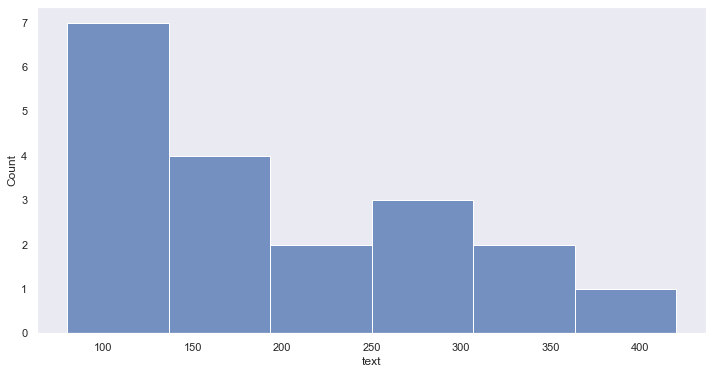

In [5]:
%%time

# Drop duplicate texts (created from unnested subject headings) & count words.
doc_len = df['text'].str.split(' ').str.len() \
    .reset_index() \
    .drop_duplicates()

# Round word count.
doc_len = np.around(doc_len['text'], decimals = -1)

doc_len = pd.DataFrame(doc_len)

# Plot graph.
sns.set(rc = {"figure.figsize": (12, 6)})
sns.set_style("dark")
ax = sns.histplot(doc_len['text'])

### Chunk texts into equal lengths.

In [6]:
%%time

chunk_size = 200

def splitText(string):
    words = string.split(' ')
    removed_stopwords = [w for w in words if w not in stop_words]
    grouped_words = [removed_stopwords[i: i + chunk_size] for i in range(0, len(removed_stopwords), chunk_size)]
    return grouped_words

df['text'] = df['text'].apply(splitText)

df = df.explode('text')

# Add word count field.
df['wordCount'] = df['text'].apply(lambda x: len(x))

# Join list of words into single string.
df['text'] = df['text'].apply(' '.join)

# Remove rows without text.
df = df.dropna(subset = ['text'])

# Remove texts with too few words (chunk_size - 50).
df = df.query('wordCount >= (@chunk_size - 50)')

df.head(3)

CPU times: user 15.3 ms, sys: 1.52 ms, total: 16.8 ms
Wall time: 15.8 ms


,file,date,source,target,subjects,references,text,wordCount
2,ESR-EDA-1892-04-07.xml,1892-04-07,richards-ellen,atkinson-edward,"Aladdin Oven,Nutrition,cooking","conro-emma,abel-mary","Boston, April 7, 1892 My dear Mr. Atkinson I ...",177
3,ESR-EDA-1890-09-29.xml,1890-09-29,richards-ellen,atkinson-edward,"Teaching,Nutrition","abel-mary,abel-john,palmer-alice",Boston Sept 29 1890 Dear Mr Atkinson I answer...,167
5,ESR-EDA-1893-05-23.xml,1893-05-23,richards-ellen,atkinson-edward,Bread,"morton-julius,shapleigh-unknown,sedgwick-willi...",Boston May 23 1893 My dear Mr Atkinson I glad...,158


## Train Topic Model

In [7]:
%%time

# Remove duplicate text rows (caused from unnesting headings) by subsetting & de-duplicating.
topics = df[['file', 'text']].drop_duplicates(subset = ['file'])

# Initialise the vectorizer with English stop words.
vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed texts.
features = vectorizer.fit_transform(topics['text'])

# Helper function (from Kapadia).
def print_topics(model, vectorizer, n_top_words):
    words = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

# Set parameters (topics set to number of unique subject headings found).
number_topics = 40
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components = number_topics, n_jobs=-1)
lda.fit(features)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, vectorizer, number_words)

Topics found via LDA:

Topic #0:
years kind especially evidently exave expect expensive explains extract eye

Topic #1:
work kitchen rumford centennial shall session certain mr make week

Topic #2:
years kind especially evidently exave expect expensive explains extract eye

Topic #3:
years kind especially evidently exave expect expensive explains extract eye

Topic #4:
years kind especially evidently exave expect expensive explains extract eye

Topic #5:
years kind especially evidently exave expect expensive explains extract eye

Topic #6:
years kind especially evidently exave expect expensive explains extract eye

Topic #7:
years kind especially evidently exave expect expensive explains extract eye

Topic #8:
years kind especially evidently exave expect expensive explains extract eye

Topic #9:
people know think gumption statements little good qualifying present use

Topic #10:
years kind especially evidently exave expect expensive explains extract eye

Topic #11:
years kind especiall

## Save pyLDAvis

In [8]:
%%time

p = pyLDAvis.sklearn.prepare(lda, features, vectorizer, mds='mmds')

pyLDAvis.save_html(p, abs_dir + "lab_space/projects/richards/topics/richards_topics-40_pyLDAvis.html")


CPU times: user 437 ms, sys: 16.3 ms, total: 454 ms
Wall time: 1.5 s
